In [1]:
using DifferentialEquations
using Plots
using LinearAlgebra
import ForwardDiff
import DiffResults
using AstrodynamicsBase
using Printf
using JSON
using CSV
using DataFrames
using ColorSchemes
using LaTeXStrings

In [2]:
include("../src/SailorMoon.jl")   # relative path to main file of module
gr()

┌ Warning: Replacing docs for `Main.SailorMoon.integrate_rk4 :: Union{Tuple{ODEProblem, Real}, Tuple{ODEProblem, Real, Union{Nothing, Vector}}, Tuple{ODEProblem, Real, Union{Nothing, Vector}, Bool}, Tuple{ODEProblem, Real, Union{Nothing, Vector}, Bool, Bool}}` in module `Main.SailorMoon`
└ @ Base.Docs docs\Docs.jl:240


Plots.GRBackend()

In [3]:
### PARAMETERS ###################################
# csv file to load the initial solution
filename  = "../run/data/grid_search_Tsit5_0717_tidal_Thrust.csv"
filename2 = "../run/data/grid_search_Tsit5_0615_NoThrust.csv"

# 3body parameter
param3b = SailorMoon.dynamics_parameters()
paramMulti = SailorMoon.multi_shoot_parameters(param3b)

##################################################


Main.SailorMoon.multishoot_params(0.005, 0.22997051088254342, 2.2997051088254343, 0.05869842280217777, 0.0024510521918983535, 5)

In [4]:
function plot_circle(radius, x, y, n=100)
    circle = zeros(2,n)
    thetas = LinRange(0.0, 2π, n)
    for i = 1:n
        circle[1,i] = radius*cos(thetas[i]) + x
        circle[2,i] = radius*sin(thetas[i]) + y
    end
    return circle
end


function interpolatecolor(cs, value, vmin, vmax)
    cs = cgrad(cs)
    color = cs[(value - vmin) / (vmax - vmin)]
    return color
end

interpolatecolor (generic function with 1 method)

In [5]:
moon     = plot_circle((1-param3b.mu2)*param3b.lstar, 0.0, 0.0)
earth    = plot_circle(param3b.mu2*param3b.lstar, 0.0, 0.0)
earth_ub = plot_circle(param3b.mu2*param3b.lstar+6375,0.0, 0.0)
earth_lb = plot_circle(param3b.mu2*param3b.lstar-6375, 0.0, 0.0)
moon_soi_outer = plot_circle((1-param3b.mu2)*param3b.lstar+66000, 0.0, 0.0);

In [6]:
fs = 12;   # omajinai for the plotting
cs = :viridis 

:viridis

In [10]:
dir_func = SailorMoon.dv_tidal_dir_sb1frame

τ_ig = 1.0

if dir_func == SailorMoon.dv_no_thrust
    τ_ig = 0.0
else 
    τ_ig = 1.0
end

# load initial guess
df = DataFrame(CSV.File(filename));
df2 = DataFrame(CSV.File(filename2));

tofs = [row.tof for row in eachrow(df)]
tofs2 = [row.tof for row in eachrow(df2)]
tof_max = maximum(tofs)
tof_min = minimum(tofs)
tof_max2 = maximum(tofs2)
tof_min2 = minimum(tofs2)

tof_max = maximum([tof_max, tof_max2])
tof_min = minimum([tof_min, tof_min2])

tof_min_days = tof_min * param3b.tstar / (24*60*60)
tof_max_days = tof_max * param3b.tstar / (24*60*60)


117.19396214850138

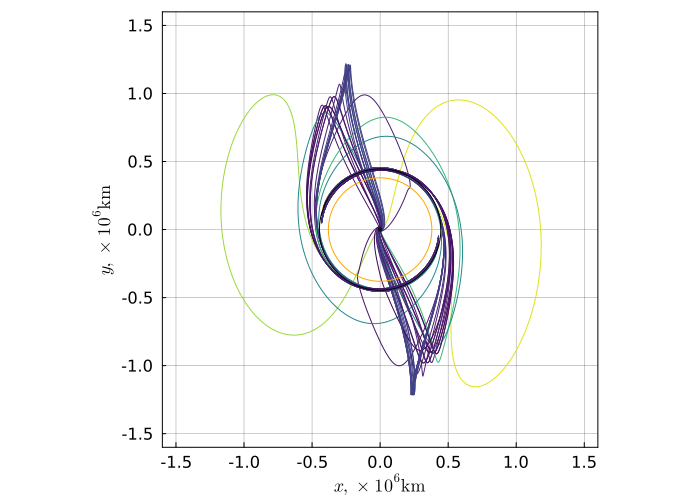

In [11]:
pcart = plot(
    size=(700,500), 
#     xlims=[383, 395], ylims=[-5,5], 
    xlims=[-1.6e6, 1.6e6], ylims=[-1.6e6,1.6e6], 
    frame_style=:box, aspect_ratio=:equal, grid=0.4, 
    legend=false, 
    xlabel=L"x, \times10^6\textrm{km}", ylabel=L"y, \times10^6\textrm{km}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

# colors = [interpolatecolor(i, 1, nrow(df)) for i in 1:nrow(df)]
tofs = [row.tof for row in eachrow(df)]
tofs2 = [row.tof for row in eachrow(df2)]
tof_max = maximum(tofs)
tof_min = minimum(tofs)
tof_max2 = maximum(tofs2)
tof_min2 = minimum(tofs2)

tof_max = maximum([tof_max, tof_max2])
tof_min = minimum([tof_min, tof_min2])

tof_min_days = tof_min * param3b.tstar / (24*60*60)
tof_max_days = tof_max * param3b.tstar / (24*60*60)

for (i, row) in enumerate( eachrow( df ) ) 
    
#     if row.lfb > 0
#         continue
#     end
    
    color = interpolatecolor(cs, row.tof*param3b.tstar/(24*60*60), tof_min_days, tof_max_days)

    tof = row.tof
    rp = row.rp_kep
    ra = row.ra_kep
    α = row.alpha
    m_rp = row.m_rp
    
    if rp < 20000 / param3b.lstar

        θsf = row.thetasf
        ϕ0  = row.phi0

        x_lpo  = row.x_lpo
        y_lpo  = row.y_lpo
        z_lpo  = row.z_lpo
        vx_lpo = row.xdot_lpo
        vy_lpo = row.ydot_lpo
        vz_lpo = row.zdot_lpo

        svf = [x_lpo, y_lpo, z_lpo, vx_lpo, vy_lpo, vz_lpo, 1.0]
        tspan = [0, -tof]
        params = [
            param3b.mu2, param3b.mus, param3b.as, pi - θsf, param3b.oml, param3b.omb, 
            1.0, 0.0, 0.0, 
            paramMulti.mdot, paramMulti.tmax, dir_func, param3b.tstar
        ]
        prob = ODEProblem(SailorMoon.rhs_bcr4bp_sb1frame2_thrust_bal!, svf, tspan, params)
        sol = solve(prob, Tsit5(); reltol=1e-12, abstol=1e-12)

        plot!(pcart, (sol[1,:] .- param3b.as) .* param3b.lstar , sol[2,:].*param3b.lstar, c=color)
    else 
        continue
    end
    
end

# dummy plot for color bar
# plot!(pcart_, [0,0], [0,1], marker_z=[15, 1], c=:rainbow, clims = (tof_min_days, tof_max_days), 
#     seriestype=:scatter, cb=:none, colorbar_title="ToF [days]")

plot!(pcart, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(pcart, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(pcart, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer",
    xaxis=(formatter=x->string(round(x / 10^6; digits=2))),
    yaxis=(formatter=y->string(round(y / 10^6, digits=1))),
)


In [9]:
pcart2 = plot(
    size=(700,500), 
#     xlims=[383, 395], ylims=[-5,5], 
    xlims=[-1.6e6, 1.6e6], ylims=[-1.6e6,1.6e6], 
    frame_style=:box, aspect_ratio=:equal, grid=0.4, 
    legend=false, 
    xlabel=L"x, \times10^6\textrm{km}", ylabel=L"y, \times10^6\textrm{km}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

# colors = [interpolatecolor(i, 1, nrow(df)) for i in 1:nrow(df)]
tofs = [row.tof for row in eachrow(df)]
tofs2 = [row.tof for row in eachrow(df2)]
tof_max = maximum(tofs)
tof_min = minimum(tofs)
tof_max2 = maximum(tofs2)
tof_min2 = minimum(tofs2)

tof_max = maximum([tof_max, tof_max2])
tof_min = minimum([tof_min, tof_min2])

tof_min_days = tof_min * param3b.tstar / (24*60*60)
tof_max_days = tof_max * param3b.tstar / (24*60*60)

for (i, row) in enumerate( eachrow( df ) ) 
    
#     if row.lfb > 0
#         continue
#     end
    
    color = interpolatecolor(cs, row.tof*param3b.tstar/(24*60*60), tof_min_days, tof_max_days)

    tof = row.tof
    rp = row.rp_kep
    ra = row.ra_kep
    α = row.alpha
    m_rp = row.m_rp
    

    θsf = row.thetasf
    ϕ0  = row.phi0

    x_lpo  = row.x_lpo
    y_lpo  = row.y_lpo
    z_lpo  = row.z_lpo
    vx_lpo = row.xdot_lpo
    vy_lpo = row.ydot_lpo
    vz_lpo = row.zdot_lpo

    svf = [x_lpo, y_lpo, z_lpo, vx_lpo, vy_lpo, vz_lpo, 1.0]
    tspan = [0, -tof]
    params = [
        param3b.mu2, param3b.mus, param3b.as, pi - θsf, param3b.oml, param3b.omb, 
        1.0, 0.0, 0.0, 
        paramMulti.mdot, paramMulti.tmax, dir_func, param3b.tstar
    ]
    prob = ODEProblem(SailorMoon.rhs_bcr4bp_sb1frame2_thrust_bal!, svf, tspan, params)
    sol = solve(prob, Tsit5(); reltol=1e-12, abstol=1e-12)

    plot!(pcart2, (sol[1,:] .- param3b.as) .* param3b.lstar , sol[2,:].*param3b.lstar, c=color)

    
end

# dummy plot for color bar
# plot!(pcart_, [0,0], [0,1], marker_z=[15, 1], c=:rainbow, clims = (tof_min_days, tof_max_days), 
#     seriestype=:scatter, cb=:none, colorbar_title="ToF [days]")

plot!(pcart2, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(pcart2, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart2, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart2, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(pcart2, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer",
    xaxis=(formatter=x->string(round(x / 10^6; digits=2))),
    yaxis=(formatter=y->string(round(y / 10^6, digits=1))),
)

### focus on the area around the Earth 

In [ ]:
# plot!(pcart, xlims=[-0.03e6, 0.03e6], ylims=[-0.3e5,0.3e5])

In [ ]:
dir_func = SailorMoon.dv_no_thrust 


pcart_ = plot(
    size=(700,500), 
#     xlims=[383, 395], ylims=[-5,5], 
    xlims=[-2e6, 2e6], ylims=[-1.75e6,1.75e6], 
    frame_style=:box, aspect_ratio=:equal, grid=0.4, 
    legend=false, 
    xlabel=L"x, \times10^6 \textrm{km}", ylabel=L"y, \times10^6 \textrm{km}",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1
);

for (i, row) in enumerate( eachrow( df2 ) ) 
    
#     if row.lfb > 0
#         continue
#     end
    
    color = interpolatecolor(cs, row.tof*param3b.tstar/(24*60*60), tof_min_days, tof_max_days)

    tof = row.tof
    rp = row.rp_kep
    ra = row.ra_kep
    α = row.alpha
    m_rp = row.m_rp

    θsf = row.thetasf
    ϕ0  = row.phi0

    x_lpo  = row.x_lpo
    y_lpo  = row.y_lpo
    z_lpo  = row.z_lpo
    vx_lpo = row.xdot_lpo
    vy_lpo = row.ydot_lpo
    vz_lpo = row.zdot_lpo

    svf = [x_lpo, y_lpo, z_lpo, vx_lpo, vy_lpo, vz_lpo, 1.0]
    tspan = [0, -tof]
    params = [
        param3b.mu2, param3b.mus, param3b.as, pi - θsf, param3b.oml, param3b.omb, 
        1.0, 0.0, 0.0, 
        paramMulti.mdot, paramMulti.tmax, dir_func, param3b.tstar
    ]
    prob = ODEProblem(SailorMoon.rhs_bcr4bp_sb1frame2_thrust_bal!, svf, tspan, params)
    sol = solve(prob, Tsit5(); reltol=1e-12, abstol=1e-12)
    
    plot!(pcart_, (sol[1,:] .- param3b.as) .* param3b.lstar , sol[2,:].*param3b.lstar, c=color)
end

# dummy plot for color bar
# plot!(pcart_, [0,0], [0,1], marker_z=[15, 1], c=:rainbow, clims = (tof_min_days, tof_max_days), 
#     seriestype=:scatter, cb=:none, colorbar_title="ToF [days]")

plot!(pcart_, earth[1,:], earth[2,:], c=:green, lw=1.0, label="earth")
plot!(pcart_, earth_ub[1,:], earth_ub[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart_, earth_lb[1,:], earth_lb[2,:], c=:black, lw=1.0, label="earth")
plot!(pcart_, moon[1,:], moon[2,:], c=:orange, lw=1.0, label="moon")
plot!(pcart_, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer",
    xaxis=(formatter=x->string(round(x / 10^6; digits=2))),
    yaxis=(formatter=y->string(round(y / 10^6, digits=1))),
)

In [ ]:
plot!(pcart, moon_soi_outer[1,:], moon_soi_outer[2,:], c=:black, lw=1.0, label="moon_soi_outer",
    xaxis=(formatter=x->string(round(x / 10^6; digits=2))),
    yaxis=(formatter=y->string(round(y / 10^6, digits=1))),
)

# annotate!(pcart, [(-2e6, 1.75e6 * 1.05, Plots.text(L"\times10^{6}", fs-1, :black, :center))])
# annotate!(pcart, [(2e6*1.1, -1.75e6, Plots.text(L"\times10^{6}", fs-1, :black, :center))])


In [ ]:
l = @layout [a{0.45w} b{0.45w} c{0.02w}]

p2 = heatmap(rand(2,2), clims=(tof_min_days, tof_max_days),
    framestyle=:none, c=cs, cbar=true, lims=(-1,0), colorbar_title="ToF,days",
    colorbar_titlefontsize=fs,
    fontsize=fs, xlabelfontsize=fs, ylabelfontsize=fs, xtickfontsize=fs-1, ytickfontsize=fs-1, legendfontsize=fs-1)

plot(pcart_, pcart, p2, layout=l, size=(1000,350), 
#     top_margin=5Plots.mm,
#     right_margin=5Plots.mm,
#     left_margin=5Plots.mm, 
    bottom_margin=5Plots.mm, 
    title=["No thrust" "max JC thrust" ""])

# savefig("ig_traj_family.png")


